In [12]:
import os

from dotenv import load_dotenv
from pathlib import Path

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import MessagesState, StateGraph
from langgraph.types import interrupt
from lib import displayAllMessages, getAIMessage
import sqlite3

conn = sqlite3.connect("../db/memory.db", check_same_thread=False)
memory = SqliteSaver(conn)

mem = MemorySaver()

config = {"configurable": {"thread_id": "human-reviewer-1"}}

env_path = Path().cwd().parent.joinpath("sample.env")

load_dotenv(override=True, dotenv_path=env_path)

os.getenv("APP_NAME")

'TEST_AGENT'

In [13]:
from lib import Logmsg


# Chat State
class ChatState(MessagesState):
    pass


llm_model = os.getenv("GPT_MODEL")

llm = ChatOpenAI(model=llm_model)


def agent_a(state: ChatState):
    return {"messages": [llm.invoke(state["messages"])]}  #for sending last 2 msg to llm




def approval(state):
    approval = interrupt("Approve? (yes/no)")

    if approval == "yes":
        return state
    else:
        return {
            "messages": state["messages"] + [
                HumanMessage(content="Rejected by human")
            ]
        }


def agent_b(state: ChatState):
    return {"messages": [llm.invoke(state["messages"])]}


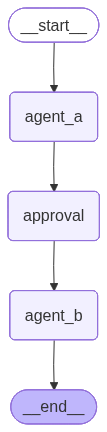

In [15]:
from IPython.core.display import Image

g = StateGraph(ChatState)

g.add_node(agent_a)
g.add_node(agent_b)
g.add_node(approval)

g.set_entry_point("agent_a")
g.add_edge("agent_a", "approval")
g.add_edge("approval", "agent_b")

gr = g.compile(checkpointer=mem)

display(Image(gr.get_graph().draw_mermaid_png()))

In [16]:
human = [HumanMessage(content="How can you help me with agentic journey")]
# (gr.stream({"messages": human }, config = config)
res = gr.invoke({"messages": human}, config=config)

In [24]:
state_snapshot = gr.get_state(config=config)


print(state_snapshot.next)

print(state_snapshot.tasks)


('approval',)
(PregelTask(id='cf89f4b8-b9ab-04d9-0e58-924e4a91be0f', name='approval', path=('__pregel_pull', 'approval'), error=None, interrupts=(Interrupt(value='Approve? (yes/no)', id='a8445e7a6be7084156c89e3b12bf635f'),), state=None, result=None),)


In [23]:
newState = gr.invoke(
    None,
    config=config,
    resume="yes"   # value returned to interrupt()
)

In [21]:
state_snapshot = gr.get_state(config=config)
print(state_snapshot)
print(state_snapshot.next)

StateSnapshot(values={'messages': [HumanMessage(content='How can you help me with agentic journey', additional_kwargs={}, response_metadata={}, id='f22a6a3a-a10e-4bba-a0e1-58b715add5f1'), AIMessage(content="I can assist you with your agentic journey by providing guidance, resources, and support in several ways:\n\n1. **Clarifying Goals**: We can work together to identify and articulate your personal and professional goals. Understanding what you want to achieve is the first step in your journey.\n\n2. **Empowerment Strategies**: I can suggest various strategies to help you build confidence and take ownership of your choices. This might include techniques for decision-making, assertiveness training, and self-advocacy.\n\n3. **Skill Development**: If there are specific skills you want to develop—whether they are related to communication, leadership, emotional intelligence, or problem-solving—I can recommend resources, exercises, and practices.\n\n4. **Overcoming Obstacles**: We can explo